In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import numpy as np
import seaborn as sns
import pickle

from tensorflow import keras
from tensorflow.keras.applications.xception import preprocess_input
#from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc
from sklearn.preprocessing import label_binarize

# Data

In [ ]:
# Liệt kê các folder con trong data_folder và đếm số file trong từng folder con
data_folder = "/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Blood Cell images for Cancer detection"

if not os.path.exists(data_folder):
  print(f"Error: Data folder '{data_folder}' does not exist.")
else:
  for subfolder in os.listdir(data_folder):
    subfolder_path = os.path.join(data_folder, subfolder)
    if os.path.isdir(subfolder_path):
      file_count = sum(1 for _ in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, _)))
      print(f"Subfolder: {subfolder}, File count: {file_count}")

Subfolder: basophil, File count: 1000
Subfolder: erythroblast, File count: 1000
Subfolder: monocyte, File count: 1000
Subfolder: myeloblast, File count: 1000
Subfolder: seg_neutrophil, File count: 1000


In [ ]:
DATADIR = "/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Blood Cell images for Cancer detection"
CATEGORIES = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
IMG_SIZE = 299
batch_size = 32

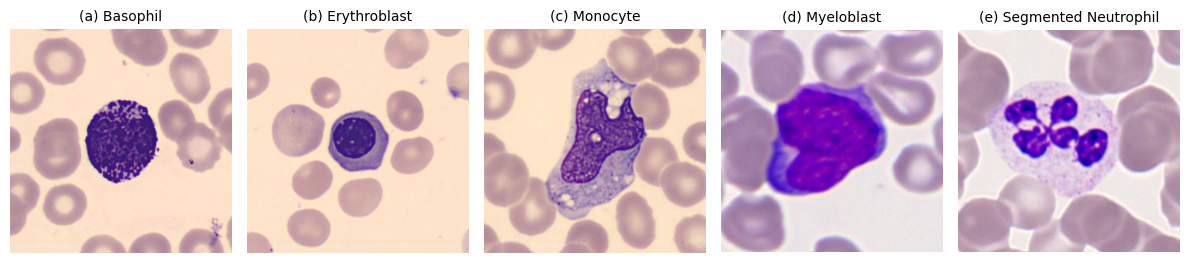

In [ ]:
# Đường dẫn đến ảnh
image_paths = [
    '/content/drive/MyDrive/UEH/Wiley bookchapter/Book Chapter/Blood Cell images for Cancer detection/basophil/BA_129641.jpg',
    '/content/drive/MyDrive/UEH/Wiley bookchapter/Book Chapter/Blood Cell images for Cancer detection/erythroblast/ERB_125091.jpg',
    '/content/drive/MyDrive/UEH/Wiley bookchapter/Book Chapter/Blood Cell images for Cancer detection/monocyte/MO_51985.jpg',
    '/content/drive/MyDrive/UEH/Wiley bookchapter/Book Chapter/Blood Cell images for Cancer detection/myeloblast/MYO_1229.jpg',
    '/content/drive/MyDrive/UEH/Wiley bookchapter/Book Chapter/Blood Cell images for Cancer detection/seg_neutrophil/NGS_0267.jpg'
]

# Nhãn tương ứng
labels = ['(a) Basophil', '(b) Erythroblast', '(c) Monocyte', '(d) Myeloblast', '(e) Segmented Neutrophil']

# Vẽ ảnh
plt.figure(figsize=(12, 3))
for i in range(5):
    img = mpimg.imread(image_paths[i])
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(labels[i], fontsize=10)

plt.tight_layout()
plt.show()

[Basophil] → BA_566824.jpg
[Erythroblast] → ERB_550354.jpg
[Monocyte] → MO_14768.jpg
[Myeloblast] → MYO_0612.jpg
[Segmented Neutrophil] → NGS_6913.jpg


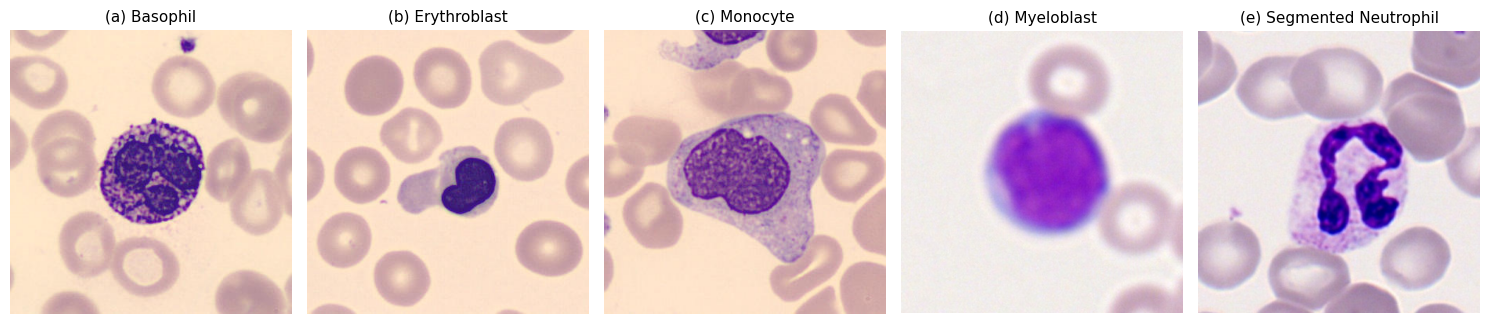

In [ ]:
LABELS = ['Basophil', 'Erythroblast', 'Monocyte', 'Myeloblast', 'Segmented Neutrophil']

# Vẽ ảnh
plt.figure(figsize=(15, 4))

for i, category in enumerate(CATEGORIES):
    img_folder = os.path.join(DATADIR, category)
    img_files = os.listdir(img_folder)

    if not img_files:
        print(f"No images found in {category}")
        continue

    img_name = random.choice(img_files)  # hoặc img_files[0] nếu bạn muốn cố định
    img_path = os.path.join(img_folder, img_name)
    img = mpimg.imread(img_path)

    plt.subplot(1, len(CATEGORIES), i+1)
    plt.imshow(img)
    plt.title(f'({chr(97+i)}) {LABELS[i]}', fontsize=11)
    plt.xlabel(img_name, fontsize=9)
    plt.axis('off')

    print(f"[{LABELS[i]}] → {img_name}")

plt.tight_layout()
plt.show()

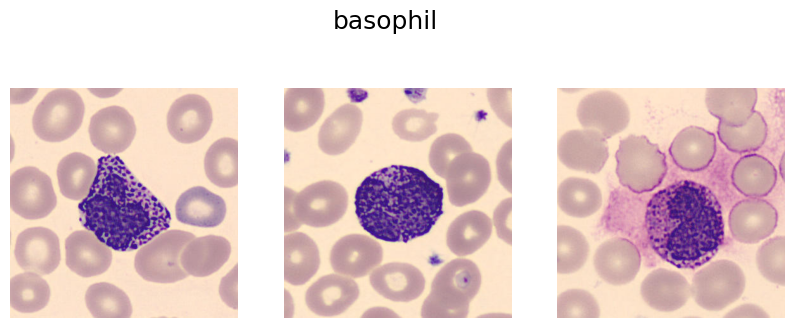

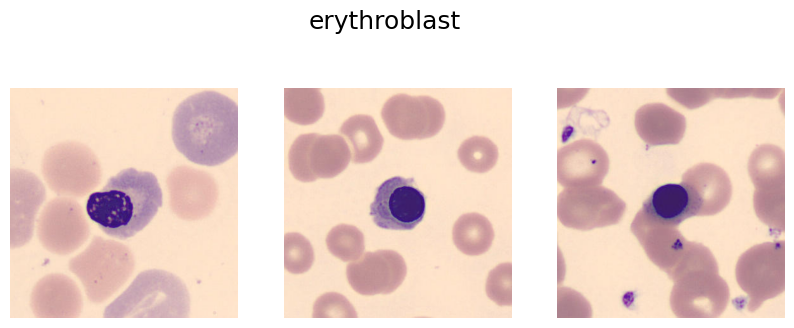

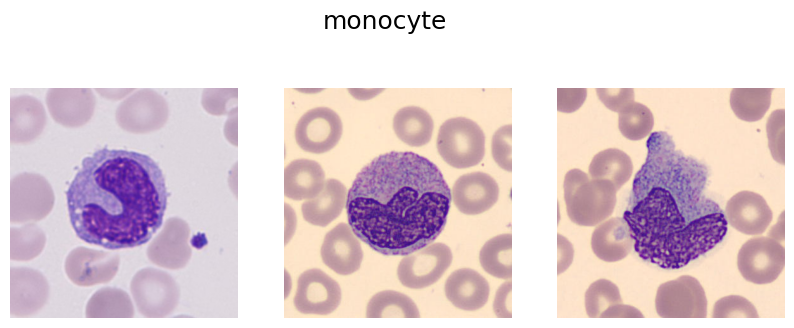

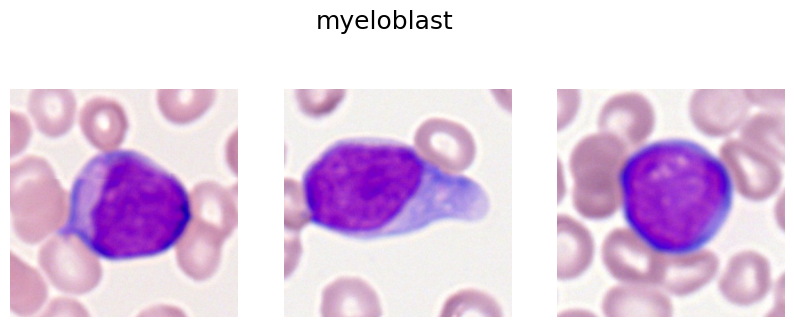

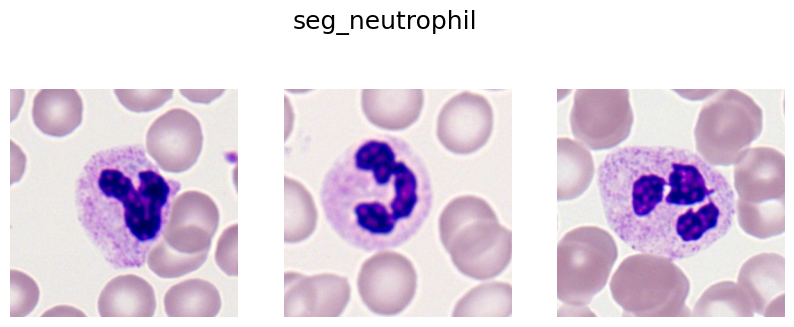

In [ ]:
# Displaying the images
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    images = os.listdir(path)

    # Initialize a subplot with 1 row and 3 columns
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        # Randomly select an image
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)
        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        # Display the image
        ax[i].imshow(img_rgb)
        # # Display the image
        # ax[i].imshow(img_array)
        ax[i].axis('off')

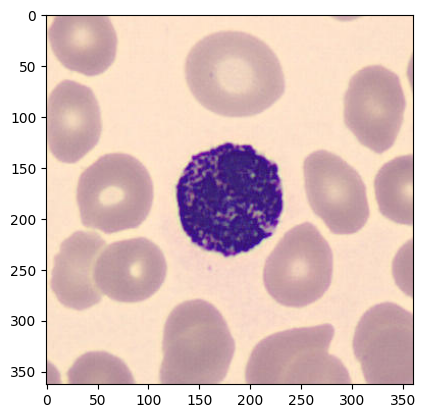

In [ ]:
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()
    break
  break

# **Preprocessing**
- resize image
- split features - labels
- split train - val - test: 80 - 10 -10

In [ ]:
# Các tham số cấu hình
batch_size = 32
IMG_SIZE = 299

# Load toàn bộ dữ liệu (không dùng validation_split)
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',          # Tự động gán nhãn theo tên thư mục
    label_mode = 'int',
    #label_mode='categorical',   # Nhãn được mã hóa one-hot cho 5 lớp
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

# Tính tổng số batch trong dataset
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

# Tính số batch cho mỗi phần
test_batches = int(0.1 * dataset_size)
val_batches = int(0.1 * dataset_size)

# Tách tập test từ đầu dataset
test_ds = full_ds.take(test_batches)

# Lấy phần còn lại cho train + validation
remaining_ds = full_ds.skip(test_batches)

# Tách tập validation từ phần còn lại
val_ds = remaining_ds.take(val_batches)

# Phần còn lại là tập huấn luyện
train_ds = remaining_ds.skip(val_batches)

Found 5000 files belonging to 5 classes.


In [ ]:
# Tiền xử lý Xception
def preprocess_data(image, label):
    image = preprocess_input(image)  # Áp dụng preprocess_input của Xception
    return image, label

# Áp dụng preprocess_input cho tất cả các dataset
train_ds = train_ds.map(preprocess_data)
val_ds = val_ds.map(preprocess_data)
test_ds = test_ds.map(preprocess_data)

In [ ]:
print("Số batch - Train:", tf.data.experimental.cardinality(train_ds).numpy())
print("Số batch - Validation:", tf.data.experimental.cardinality(val_ds).numpy())
print("Số batch - Test:", tf.data.experimental.cardinality(test_ds).numpy())

Số batch - Train: 127
Số batch - Validation: 15
Số batch - Test: 15


# Train

In [ ]:
# Xception model
xception_model = Xception(weights = 'imagenet',include_top = False,input_shape = (IMG_SIZE, IMG_SIZE, 3),classes=len(CATEGORIES))

In [ ]:
# freezing the bottom (conv) layers
for layer in xception_model.layers:
  layer.trainable = False

In [ ]:
model = keras.Sequential([xception_model,keras.layers.GlobalAveragePooling2D(),keras.layers.Dense(512, activation='relu'),
                          keras.layers.Dense(128, activation='relu'),keras.layers.Dropout(0.25),  # Thêm dropout
                          keras.layers.Dense(len(CATEGORIES), activation='softmax'),])

In [ ]:
# Compilation
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy', # For multi-class classification
              metrics = ['accuracy'])

# Áp dụng EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,976,877 (83.84 MB)

 Trainable params: 1,115,397 (4.25 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

# **Train model**

In [ ]:
# Huấn luyện mô hình với tập dữ liệu đã tăng cường và validation
history = model.fit(train_ds,validation_data=val_ds,epochs=20,callbacks=[early_stopping])

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 53s 328ms/step - accuracy: 0.7405 - loss: 0.6151 - val_accuracy: 0.9542 - val_loss: 0.1241
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 35s 247ms/step - accuracy: 0.9456 - loss: 0.1579 - val_accuracy: 0.9667 - val_loss: 0.1122
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 245ms/step - accuracy: 0.9597 - loss: 0.1144 - val_accuracy: 0.9438 - val_loss: 0.1678
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.9656 - loss: 0.0918 - val_accuracy: 0.9667 - val_loss: 0.1103
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 33s 242ms/step - accuracy: 0.9728 - loss: 0.0808 - val_accuracy: 0.9708 - val_loss: 0.1024
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.9804 - loss: 0.0549 - val_accuracy: 0.9729 - val_loss: 0.0912
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.9769 - loss: 0.0683 - val_accuracy: 0.9708 - val_loss: 0.0865
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.9786 - loss: 0

Lưu model đã train và history để về sau có thể dùng

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Saved Models/xception.keras')

# Save the training history
with open('/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Saved Models/xception_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Đánh giá

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Saved Models/xception.keras')

# Load the training history (optional, for analysis)
with open('/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Saved Models/xception_training_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Example prediction (replace with your actual test data)
IMG_SIZE = 299
CATEGORIES = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

def prepare(filepath):
    IMG_SIZE = 299
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

test_image_path = "/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Blood Cell images for Cancer detection/basophil/BA_100102.jpg" # Example path
prediction = model.predict([prepare(test_image_path)])
predicted_class = np.argmax(prediction)
print(f"Predicted class: {CATEGORIES[predicted_class]}")
print(f"Prediction probabilities: {prediction}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_7
Received: inputs=('Tensor(shape=(1, 299, 299, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: erythroblast
Prediction probabilities: [[0. 1. 0. 0. 0.]]


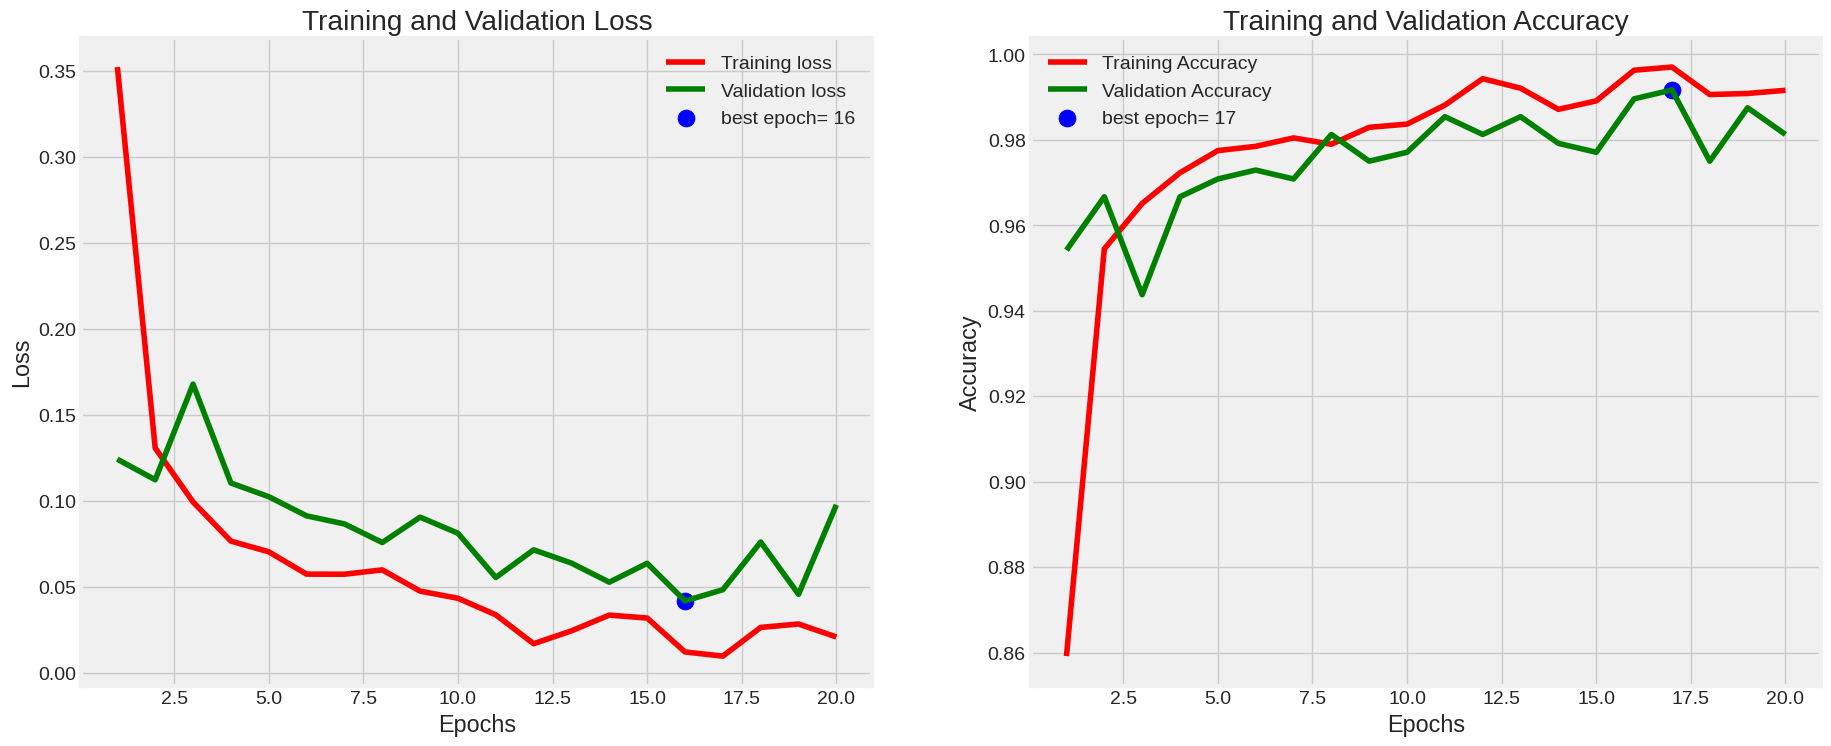

In [ ]:
tr_acc = history['accuracy']
tr_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
best_epoch = np.argmin(history['val_loss']) + 1
print(f"Best epoch selected by EarlyStopping: {best_epoch}")

Best epoch selected by EarlyStopping: 16


In [ ]:
# ===== Đánh giá mô hình trên tập test =====
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 844ms/step - accuracy: 0.9647 - loss: 0.1270
Test accuracy: 0.97


In [ ]:
# ===== Dự đoán và đánh giá chi tiết =====
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    y_true.extend(y_batch.numpy())
    y_pred.extend(model.predict(x_batch, verbose=0))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)

# Trường hợp nhãn vẫn là one-hot (phòng hờ)
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true_classes = np.argmax(y_true, axis=1)
else:
    y_true_classes = y_true

# ===== 5. Classification report =====
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       100
           1       0.98      0.98      0.98        97
           2       0.97      0.97      0.97        99
           3       0.98      0.99      0.98        91
           4       0.99      0.98      0.98        93

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



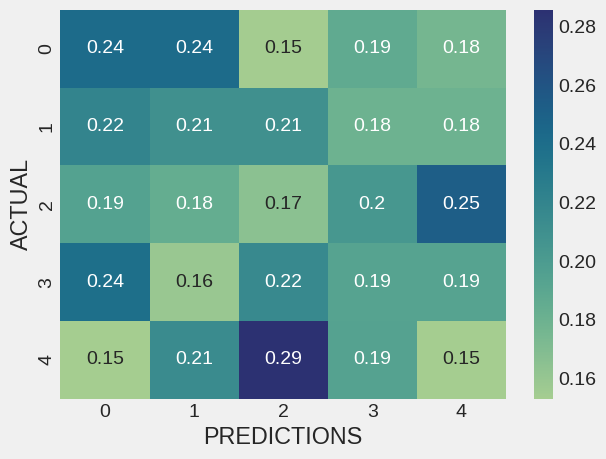

In [ ]:
#confusion matrix
# Extract true labels from the test_ds
y_true_cf = []
for _, y_batch in test_ds:
    y_true_cf.extend(y_batch.numpy())
y_true_cf = np.array(y_true_cf)

cf = confusion_matrix(y_true_cf, y_pred_classes, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest');
plt.xlabel('PREDICTIONS');
plt.ylabel('ACTUAL');

In [ ]:
plt.style.use('seaborn-v0_8-white')

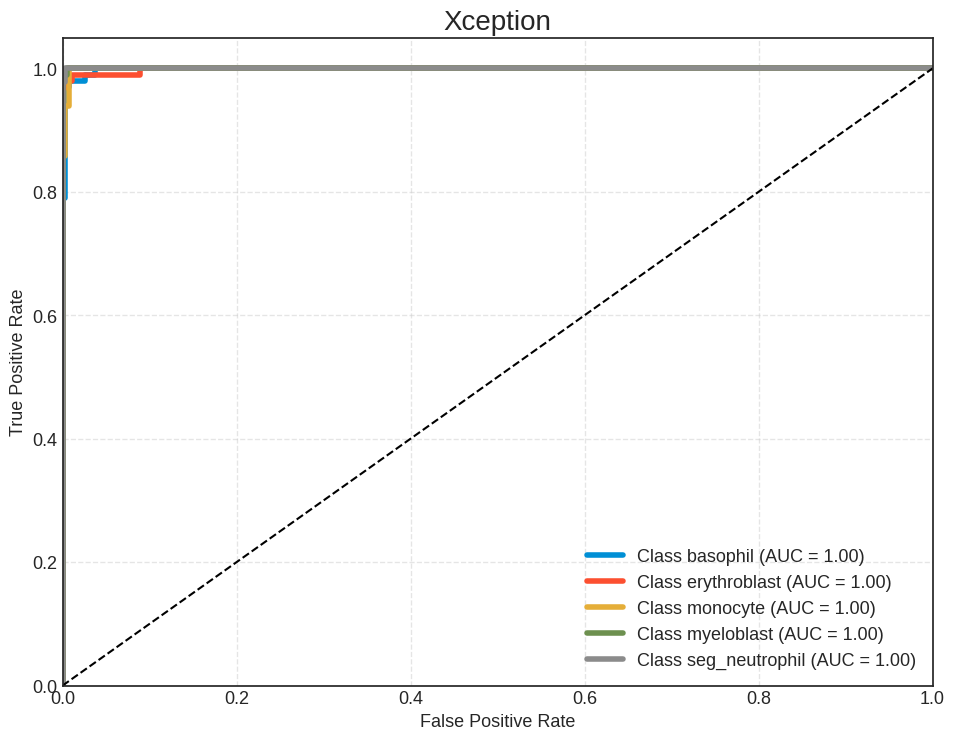

In [ ]:
# Binarize y_true nếu đang ở dạng label (1D)
n_classes = 5
y_true_bin = label_binarize(y_true_classes, classes=list(range(n_classes)))

# Tính xác suất dự đoán (y_pred đã là xác suất softmax)
y_score = y_pred  # đã có từ model.predict()

# Tính ROC curve và AUC cho từng lớp
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tính ROC micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Vẽ biểu đồ ROC
plt.figure(figsize=(10, 8))
for i in range(n_classes):
  plt.plot(fpr[i], tpr[i], label=f'Class {CATEGORIES[i]} (AUC = {roc_auc[i]:.2f})')

# Đường chéo ngẫu nhiên
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Xception', fontsize=20)
plt.legend(loc="lower right", fontsize=13)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

# **Vẽ GRAD CAM**

In [3]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Saved Models/xception.keras')

# Build model với dummy input
dummy_input = tf.zeros((1, 299, 299, 3))
_ = model(dummy_input)

In [4]:
for layer in model.layers:
  print(layer.name)
  if isinstance(layer, tf.keras.Model):
    for sub in layer.layers:
      print(" └──", sub.name)

xception
 └── input_layer_6
 └── block1_conv1
 └── block1_conv1_bn
 └── block1_conv1_act
 └── block1_conv2
 └── block1_conv2_bn
 └── block1_conv2_act
 └── block2_sepconv1
 └── block2_sepconv1_bn
 └── block2_sepconv2_act
 └── block2_sepconv2
 └── block2_sepconv2_bn
 └── conv2d_12
 └── block2_pool
 └── batch_normalization_12
 └── add_36
 └── block3_sepconv1_act
 └── block3_sepconv1
 └── block3_sepconv1_bn
 └── block3_sepconv2_act
 └── block3_sepconv2
 └── block3_sepconv2_bn
 └── conv2d_13
 └── block3_pool
 └── batch_normalization_13
 └── add_37
 └── block4_sepconv1_act
 └── block4_sepconv1
 └── block4_sepconv1_bn
 └── block4_sepconv2_act
 └── block4_sepconv2
 └── block4_sepconv2_bn
 └── conv2d_14
 └── block4_pool
 └── batch_normalization_14
 └── add_38
 └── block5_sepconv1_act
 └── block5_sepconv1
 └── block5_sepconv1_bn
 └── block5_sepconv2_act
 └── block5_sepconv2
 └── block5_sepconv2_bn
 └── block5_sepconv3_act
 └── block5_sepconv3
 └── block5_sepconv3_bn
 └── add_39
 └── block6_sepco

In [5]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Lấy mô hình feature extractor từ layer conv cuối của Xception
    xception_model = model.get_layer("xception")
    last_conv_layer = xception_model.get_layer(last_conv_layer_name)

    feature_extractor = tf.keras.Model(inputs=xception_model.input,outputs=last_conv_layer.output)

    # Xây lại phần classifier (chỉ từ sau GAP trở đi)
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Bỏ qua cả xception và lớp GlobalAveragePooling2D gốc
    skip_layers = {'xception', 'global_average_pooling2d_3'}
    for layer in model.layers:
        if layer.name in skip_layers:
            continue
        x = layer(x)

    classifier_model = keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        conv_outputs = feature_extractor(img_array, training=False)
        tape.watch(conv_outputs)

        preds = classifier_model(conv_outputs, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    heatmap = heatmap if max_val == 0 else heatmap / max_val

    return heatmap.numpy()

# Load ảnh để Grad-CAM
def preprocess_image(img_path, target_size=(299,299)):
    img = keras.utils.load_img(img_path, target_size=target_size)
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Overlay heatmap lên ảnh gốc
def save_and_display_gradcam(img_path, heatmap, true_label, svg_path, alpha=0.8, class_names=['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']):
    # Load ảnh gốc
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Chuyển heatmap về dạng đúng
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Resize heatmap về cùng kích thước ảnh gốc
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Chuyển đổi heatmap từ BGR sang RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay heatmap lên ảnh gốc
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    # Dự đoán nhãn của ảnh
    predictions = model.predict(preprocess_image(img_path))
    predicted_class = np.argmax(predictions)
    predicted_label = class_names[predicted_class] if class_names else f"Class {predicted_class}"

    # Hiển thị ảnh gốc, heatmap và ảnh overlay
    plt.figure(figsize=(15,5))

    # Ảnh gốc
    plt.subplot(1, 3, 1)
    plt.imshow(img.astype('uint8'))
    plt.title('Original Image')
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    # Ảnh overlay
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f'Overlayed Image\nTrue: {true_label}, Pred: {predicted_label}')
    plt.axis('off')

    plt.tight_layout()

    # Save the figure as SVG
    plt.savefig(svg_path, format='svg')

    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_6']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


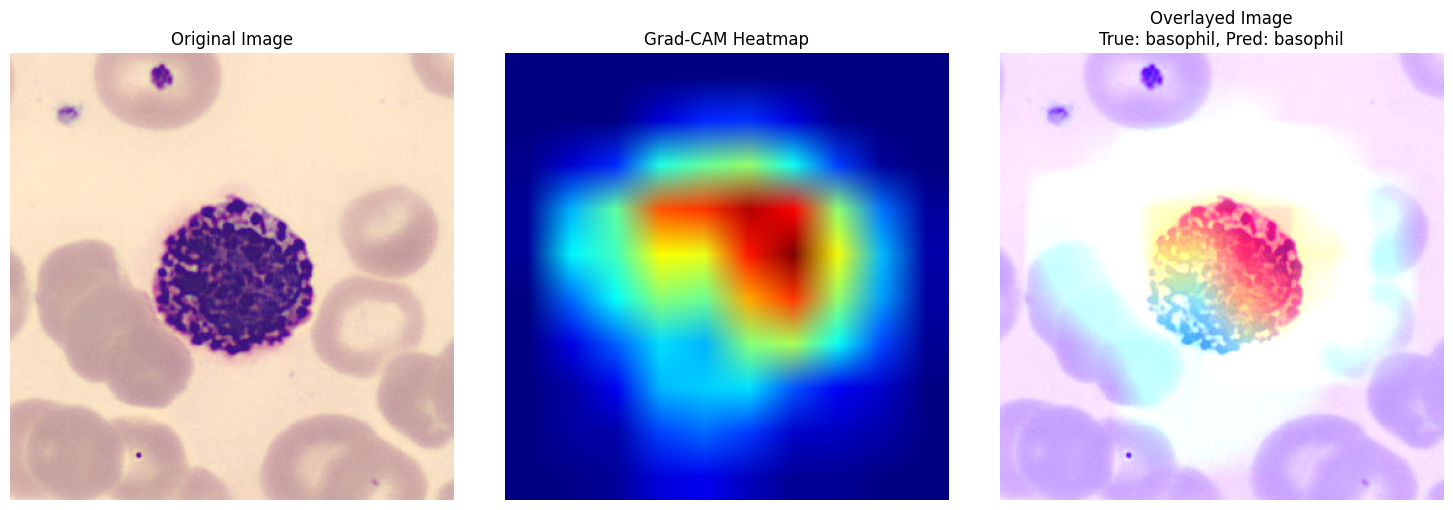

In [6]:
# Đường dẫn ảnh muốn test
img_path = '/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Blood Cell images for Cancer detection/basophil/BA_396998.jpg'

# Tiền xử lý ảnh
img_array = preprocess_image(img_path)

# Tạo heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Overlay lên ảnh
save_and_display_gradcam(img_path, heatmap, true_label='basophil',svg_path='gradcam_output.svg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


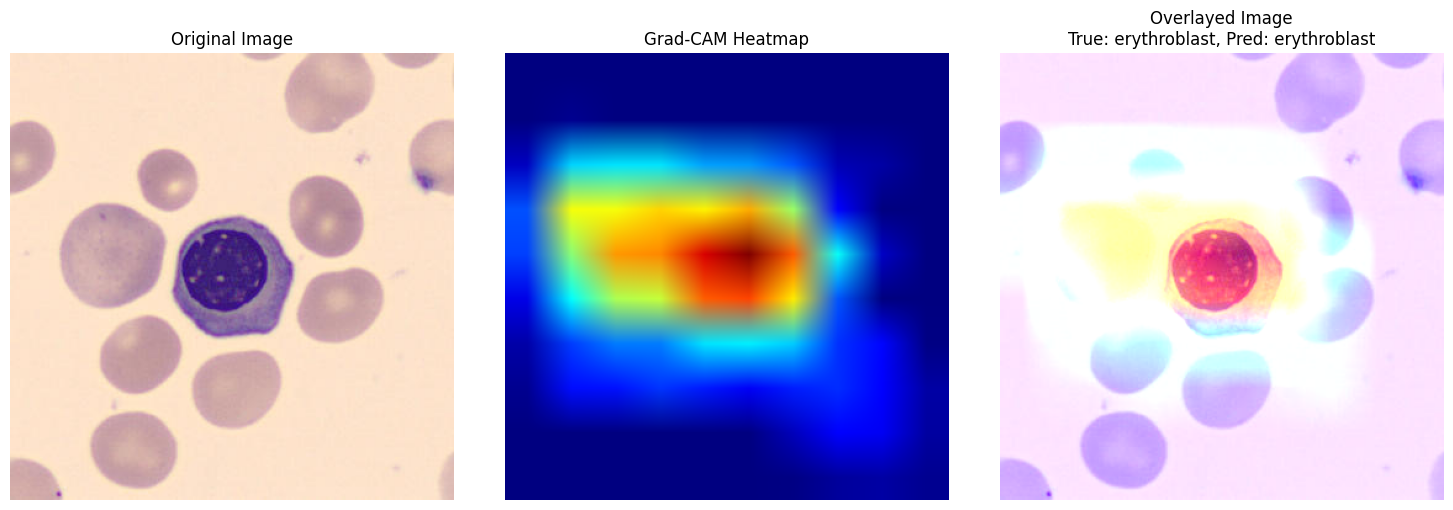

In [7]:
# Đường dẫn ảnh muốn test
img_path = '/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Blood Cell images for Cancer detection/erythroblast/ERB_125091.jpg'

# Tiền xử lý ảnh
img_array = preprocess_image(img_path)

# Tạo heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Overlay lên ảnh
save_and_display_gradcam(img_path, heatmap, true_label='erythroblast',svg_path='gradcam_output.svg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


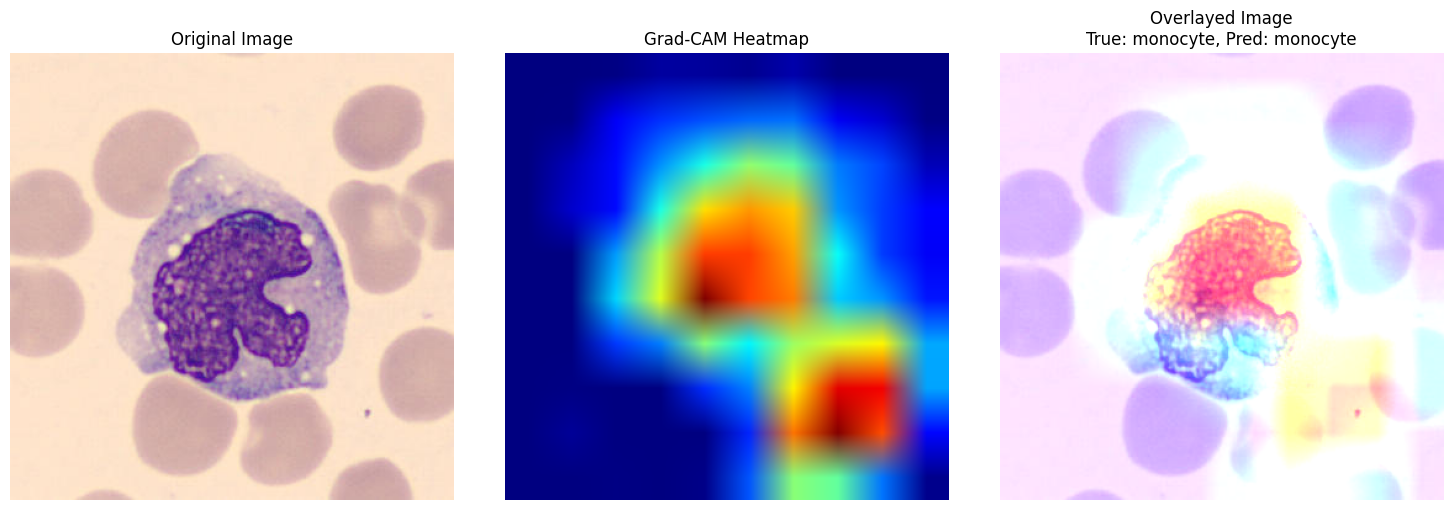

In [8]:
# Đường dẫn ảnh muốn test
img_path = '/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Blood Cell images for Cancer detection/monocyte/MO_108531.jpg'

# Tiền xử lý ảnh
img_array = preprocess_image(img_path)

# Tạo heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Overlay lên ảnh
save_and_display_gradcam(img_path, heatmap, true_label='monocyte',svg_path='gradcam_output.svg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


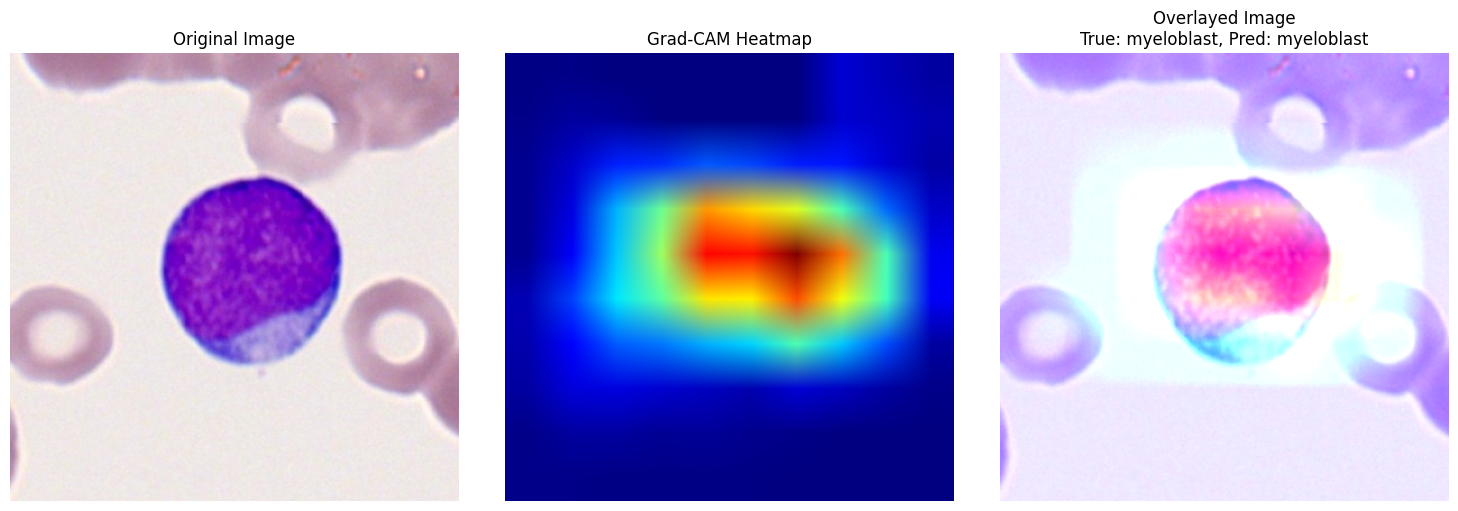

In [11]:
# Đường dẫn ảnh muốn test
img_path = '/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Blood Cell images for Cancer detection/myeloblast/MYO_0013.jpg'

# Tiền xử lý ảnh
img_array = preprocess_image(img_path)

# Tạo heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Overlay lên ảnh
save_and_display_gradcam(img_path, heatmap, true_label='myeloblast',svg_path='gradcam_output.svg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


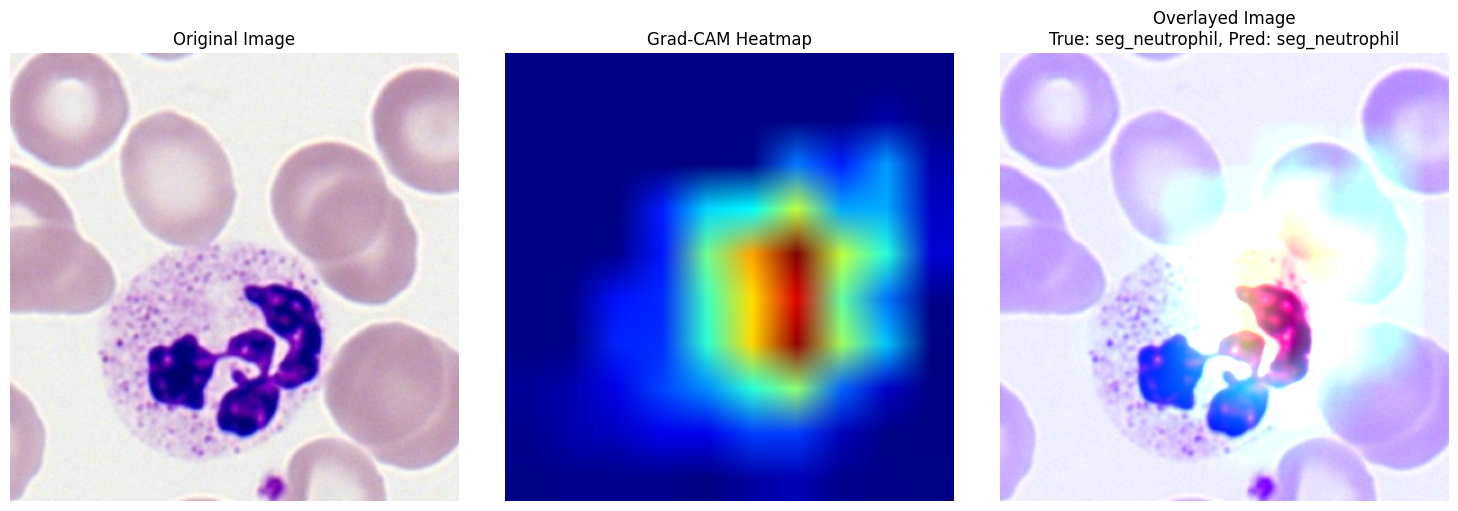

In [12]:
# Đường dẫn ảnh muốn test
img_path = '/content/drive/MyDrive/Tổng hợp Đồ án Tốt nghiệp/Blood Cell images for Cancer detection/seg_neutrophil/NGS_0099.jpg'

# Tiền xử lý ảnh
img_array = preprocess_image(img_path)

# Tạo heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Overlay lên ảnh
save_and_display_gradcam(img_path, heatmap, true_label='seg_neutrophil',svg_path='gradcam_output.svg')